# Eye for Blind – Image Captioning with Attention

# 1. Objective

Eye for Blind: An Assistive Image Captioning System with Visual Attention

This project implements a deep learning model that generates natural language descriptions of images, particularly aimed at visually impaired users. The model leverages an attention mechanism to selectively focus on image regions when generating each word, mimicking human vision.

Inspired by "Show, Attend and Tell" (Xu et al., 2015), this implementation:
1. Uses a CNN encoder (InceptionV3) to extract image features.
2. Applies additive (Bahdanau) attention during decoding.
3. Employs a decoder LSTM to generate captions.
4. Converts generated captions to speech using gTTS.

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
# 0 (default): All messages (INFO, WARNING, ERROR) are logged.
# 1: INFO messages are not printed.
# 2: INFO and WARNING messages are not printed.
# 3: INFO, WARNING, and ERROR messages are not printed.

import re
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from PIL import Image
from typing import Dict, List, Tuple, Optional
import tensorflow as tf #type: ignore
from tensorflow.keras import layers, Model #type: ignore
from tensorflow.keras.optimizers.schedules import CosineDecay #type: ignore
from tensorflow.keras.losses import SparseCategoricalCrossentropy #type: ignore
from tensorflow.keras.preprocessing.text import Tokenizer #type: ignore
from tensorflow.keras.preprocessing.sequence import pad_sequences #type: ignore
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction #type: ignore
from gtts import gTTS #type: ignore
from IPython.display import Audio, display
import tqdm

In [2]:
CONFIG = {
    'subset_ratio' : 1.0,
    'image_dir': '/home/flickr30k_images/flickr30k_images',
    'caption_file': '/home/flickr30k_images/flickr30k_images/results.csv',
    
    # GPU Utilization
    'batch_size': 128,           # Fully utilize 48GB VRAM; reduce if OOM
    'buffer_size': 10000,        # Larger shuffle buffer helps training stability
    
    # Model Capacity
    'max_length': 30,            # Reasonable for captions
    'embedding_dim': 512,        # Good for attention + LSTM
    'units': 512,                # LSTM/Attention size
    
    # Training Behavior
    'seed': 42,
    'epochs': 20,                # Slightly more for small dataset
    'patience': 8,               # Early stopping tolerance
    'learning_rate': 3e-4,       # Lower for small datasets to reduce overfitting
    'grad_clip_value': 5.0,      # Prevent exploding gradients
    'scheduled_sampling_max_prob' : 0.25,    # final ε
    
    # Vocabulary
    'vocab_min_count': 3,        # Include more words for small run
    
    # Output & Precision
    'checkpoint_dir': './checkpoints/10pct',
    'mixed_precision': False,     # RTX 6000 Ada has 4th-gen Tensor Cores—use them
}

In [3]:
# Set random seeds for reproducibility
tf.random.set_seed(CONFIG['seed'])
np.random.seed(CONFIG['seed'])
random.seed(CONFIG['seed'])

# Mixed precision policy - RTX 6000 Ada has excellent mixed precision support
if CONFIG['mixed_precision']:
    policy = tf.keras.mixed_precision.Policy('mixed_float16')
    tf.keras.mixed_precision.set_global_policy(policy)
    print("Mixed precision enabled for RTX 6000 Ada")

# Single GPU setup
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    # Enable memory growth for RTX 6000 Ada
    for gpu in physical_devices:
        tf.config.experimental.set_memory_growth(gpu, True)
    
    # Use default strategy for single GPU
    strategy = tf.distribute.get_strategy()
    print(f"Using single GPU: {physical_devices[0].name}, batch size={CONFIG['batch_size']}")
else:
    print("No GPUs found, using CPU")
    strategy = tf.distribute.get_strategy()

# Constants
AUTOTUNE = tf.data.AUTOTUNE

Using single GPU: /physical_device:GPU:0, batch size=128


In [4]:
class DataProcessor:
    def __init__(self, config):
        self.config = config
        self.captions_dict = dict()
        self.tokenizer = None
        self.vocab_size = 0
        self.train_data = []
        self.val_data = []
        self.test_data = []
    
    def load_captions(self) -> Dict[str, List[str]]:
        """Load and convert pipe-delimited Flickr-style caption file to a dict."""
        print(f"Loading captions from {self.config['caption_file']}")
        df = pd.read_csv(self.config['caption_file'], sep='|', header=None, 
                         names=['image_name', 'comment_number', 'comment'], engine='python')
        df['image_name'] = df['image_name'].str.strip()
        df['comment'] = df['comment'].str.strip()
        
        caption_map = {}
        for img, group in df.groupby('image_name'):
            caption_map[img] = group['comment'].tolist()
        
        self.captions_dict = caption_map
        print(f"Loaded {len(caption_map)} images with captions")
        return caption_map
    
    def display_samples(self, num_samples: int = 3):
        """Display random images with all their associated captions."""
        if not self.captions_dict:
            self.load_captions()

        sample_keys = random.sample(list(self.captions_dict.keys()), min(num_samples, len(self.captions_dict)))

        for key in sample_keys:
            img_path = os.path.join(self.config['image_dir'], key)
            try:
                img = Image.open(img_path)
                plt.figure(figsize=(8, 6))
                plt.imshow(img)
                plt.axis('off')
                plt.title(key)
                plt.show()

                for cap in self.captions_dict[key]:
                    print(f"- {cap}")
                print()
            except Exception as e:
                print(f"Error loading image {key}: {e}")

    def preprocess_caption(self, caption: str) -> Optional[str]:
        """Clean and format caption text."""
        if caption is None or not isinstance(caption, str):
            return None
        caption = caption.lower()
        caption = re.sub(r"[^a-z0-9.,? ]", "", caption)
        return f"<start> {caption.strip()} <end>"

    def prepare_captions(self, subset_ratio=1.0):
        """Process captions, build tokenizer & train/val/test splits."""
        if not self.captions_dict:
            self.load_captions()

        # --- 1. clean & tag ----------------------------------------------------
        all_captions = []
        for caps in self.captions_dict.values():
            for c in caps:
                p = self.preprocess_caption(c)
                if p:
                    all_captions.append(p)

        word_counts = Counter(w for cap in all_captions for w in cap.split())
        valid_words = {w for w, cnt in word_counts.items()
                    if cnt >= self.config['vocab_min_count']}

        def keep(c):
            return all(w in valid_words or w in ('<start>', '<end>') for w in c.split())

        filtered = [c for c in all_captions if keep(c)]

        # --- 2. determine max length ------------------------------------------
        lengths = [len(c.split()) for c in filtered]
        self.config['max_length'] = int(np.percentile(lengths, 95))
        print(f"max_length set to {self.config['max_length']}")

        # --- 3. build tokenizer (NO filters so < and > stay) -------------------
        tokenizer = Tokenizer(oov_token="<unk>", filters='', lower=True)
        tokenizer.fit_on_texts(filtered)
        self.tokenizer = tokenizer
        self.vocab_size = len(tokenizer.word_index) + 1
        print(f"vocab size = {self.vocab_size}")

        # --- 4. build (image, caption) list ------------------------------------
        pairs = []
        for img, caps in self.captions_dict.items():
            for c in caps:
                p = self.preprocess_caption(c)
                if p and keep(p):
                    pairs.append((img, p))

        if subset_ratio < 1.0:
            pairs = pairs[:int(len(pairs) * subset_ratio)]
            print(f"subset: {len(pairs)} pairs")

        random.shuffle(pairs)
        n = len(pairs)
        self.train_data, self.val_data, self.test_data = (
            pairs[:int(0.8*n)],
            pairs[int(0.8*n):int(0.9*n)],
            pairs[int(0.9*n):],
        )
        print(f"split  →  train {len(self.train_data)} | val {len(self.val_data)} | test {len(self.test_data)}")

        return filtered
        
    def encode_caption(self, caption: str) -> Tuple[np.ndarray, int]:
        """Convert caption text to sequence of token ids."""
        if self.tokenizer is None:
            raise ValueError("Tokenizer not initialized. Call prepare_captions first.")
        
        seq = self.tokenizer.texts_to_sequences([caption])[0]
        padded_seq = pad_sequences([seq], maxlen=self.config['max_length'], padding='post')[0]
        return padded_seq, len(seq)

    @tf.function(input_signature=[tf.TensorSpec([], tf.string)])
    def _base_decode(self, path: tf.Tensor) -> tf.Tensor:
        img = tf.io.read_file(path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.convert_image_dtype(img, tf.float32)          # [0,1]
        return img                                                   # (h,w,3)

    @tf.function(input_signature=[tf.TensorSpec([], tf.string)])
    def load_image_train(self, path: tf.Tensor) -> tf.Tensor:
        """Augment + preprocess (training only)."""
        img = self._base_decode(path)
        img = tf.image.random_flip_left_right(img)                   # aug ①

        # resize shorter side→342 then *random* crop 299×299
        shape = tf.shape(img)[:2]
        scale = 342. / tf.cast(tf.reduce_min(shape), tf.float32)
        new_hw = tf.cast(tf.cast(shape, tf.float32) * scale, tf.int32)
        img = tf.image.resize(img, new_hw)
        img = tf.image.random_crop(img, size=[299, 299, 3])          # aug ②

        img = tf.keras.applications.inception_v3.preprocess_input(img)
        return tf.ensure_shape(img, [299, 299, 3])

    @tf.function(input_signature=[tf.TensorSpec([], tf.string)])
    def load_image_eval(self, path: tf.Tensor) -> tf.Tensor:
        """Deterministic centre-crop (validation / inference)."""
        img = self._base_decode(path)

        # resize shorter side→342 then *central* crop 299×299
        shape = tf.shape(img)[:2]
        scale = 342. / tf.cast(tf.reduce_min(shape), tf.float32)
        new_hw = tf.cast(tf.cast(shape, tf.float32) * scale, tf.int32)
        img = tf.image.resize(img, new_hw)
        img = tf.image.resize_with_crop_or_pad(img, 299, 299)

        img = tf.keras.applications.inception_v3.preprocess_input(img)
        return tf.ensure_shape(img, [299, 299, 3])

    def data_generator(self, data):
        """Generator for *training* / *val* datasets."""
        for img, cap in data:
            img_path = os.path.join(self.config['image_dir'], img)
            img_tensor = self.load_image_train(tf.convert_to_tensor(img_path))
            token_ids, cap_len = self.encode_caption(cap)
            yield img_tensor, token_ids, cap_len
    
    def build_dataset(self, data, shuffle=True, cache=True, training: bool=True):
        """Create a tf.data.Dataset optimized for single GPU."""
        output_signature = (
            tf.TensorSpec((299, 299, 3), tf.float32),
            tf.TensorSpec((self.config['max_length'],), tf.int32),
            tf.TensorSpec((), tf.int32)
        )

        ds = tf.data.Dataset.from_generator(
            lambda: self.data_generator(data),
            output_signature=output_signature
        )

        if cache:
            ds = ds.cache()
        if shuffle:
            ds = ds.shuffle(self.config['buffer_size'])

        ds = ds.batch(self.config['batch_size'])
        ds = ds.prefetch(AUTOTUNE)
        return ds

    def prepare_datasets(self):
        """Prepare all datasets for training/validation/testing."""
        if not self.train_data:
            self.prepare_captions()

        print("Building datasets...")
        train_ds = self.build_dataset(self.train_data)
        val_ds = self.build_dataset(self.val_data)
        test_ds = self.build_dataset(self.test_data, shuffle=False)
        
        return train_ds, val_ds, test_ds

In [5]:
class Encoder(Model):
    """
    Inception-V3 feature extractor with an optional
    `unfreeze_top_layers()` helper for later fine-tuning.
    """
    def __init__(self):
        super().__init__(name="encoder")
        base = tf.keras.applications.InceptionV3(
            include_top=False, weights='imagenet',
            input_shape=(299, 299, 3))
        base.trainable = False                                      # phase-1: frozen
        self.cnn = Model(inputs=base.input, outputs=base.get_layer('mixed10').output)
        self.reshape = layers.Reshape((-1, 2048))                  # L=64 for 8×8 grid

    def unfreeze_top_layers(self, n: int = 2):
        """
        Fine-tune: unfreeze the last *n* Inception blocks (default: mixed9 & mixed10).
        Call **after** initial caption training for best accuracy.
        """
        for layer in self.cnn.layers[-n:]:
            layer.trainable = True

    def call(self, x):                                             # (B,299,299,3)
        x = self.cnn(x)                                            # (B,8,8,2048)
        return self.reshape(x)                                     # (B,64,2048)

In [6]:
class BahdanauAttention(layers.Layer):
    def __init__(self, units):
        super().__init__(name="attention")
        self.W1 = layers.Dense(units)
        self.W2 = layers.Dense(units)
        self.V = layers.Dense(1)
    
    def call(self, features, hidden):
        hidden_time = tf.expand_dims(hidden, 1)
        score = self.V(tf.nn.tanh(self.W1(features) + self.W2(hidden_time)))
        attention_weights = tf.nn.softmax(score, axis=1)
        context_vector = tf.reduce_sum(attention_weights * features, axis=1)
        return context_vector, tf.squeeze(attention_weights, -1)

In [7]:
class Decoder(Model):
    """
    Attention decoder with:
      • β-gate
      • **max-out** deep-output layer  (improves accuracy a bit)
    """
    def __init__(self, embedding_dim: int, units: int, vocab_size: int):
        super().__init__(name="decoder")
        self.units = units

        self.embedding = layers.Embedding(vocab_size, embedding_dim)
        self.attention = BahdanauAttention(units)
        self.f_beta    = layers.Dense(1, activation="sigmoid")          # βₜ
        self.lstm      = layers.LSTM(units, return_sequences=True, return_state=True)
        self.dropout   = layers.Dropout(0.3)

        # max-out projection: 2 × units → reduce_max → units
        self.deep_proj = layers.Dense(units * 2)                        # W_o
        self.fc        = layers.Dense(vocab_size)                       # final soft-max

    def call(self, x, features, hidden, cell):
        context, alpha = self.attention(features, hidden)               # (B,2048)
        context = self.f_beta(hidden) * context                         # gated

        x = self.embedding(x)                                           # (B,1,E)
        lstm_input = tf.concat([tf.expand_dims(context, 1), x], -1)     # (B,1,2048+E)

        hidden = tf.cast(hidden, lstm_input.dtype)
        cell   = tf.cast(cell,   lstm_input.dtype)

        lstm_out, h_t, c_t = self.lstm(lstm_input, initial_state=[hidden, cell])
        lstm_out = tf.squeeze(lstm_out, 1)                               # (B,units)

        # ---------- max-out deep-output layer ----------
        proj = self.deep_proj(tf.concat([lstm_out, context], -1))        # (B,2*units)
        proj = tf.reshape(proj, (-1, self.units, 2))                     # (B,units,2)
        maxout = tf.reduce_max(proj, axis=-1)                            # (B,units)
        maxout = self.dropout(maxout)

        logits = self.fc(maxout)                                         # (B,vocab)
        return tf.expand_dims(logits, 1), h_t, c_t, alpha

In [8]:
class ImageCaptioningModel:
    def __init__(self, config, processor):
        self.config          = config
        self.processor       = processor
        self.encoder         = None
        self.decoder         = None
        self.optimizer       = None
        self.loss_fn         = None
        self.ckpt_manager    = None

        self.best_bleu       = 0.0
        self.train_loss_log  = []
        self.train_bleu_log  = []
        self.val_bleu_log    = []
        self.bleu_subset_idx = None  

        self.smoothie = SmoothingFunction().method4
    
    def build_model(self):
        """Build model for single GPU - no distribution strategy needed."""
        print("Building model for single GPU...")
        self.encoder = Encoder()
        self.decoder = Decoder(
            embedding_dim=self.config['embedding_dim'], 
            units=self.config['units'], 
            vocab_size=self.processor.vocab_size
        )
        
        lr_schedule = CosineDecay(
            initial_learning_rate=self.config['learning_rate'],
            decay_steps=10000
        )
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
        self.loss_fn = SparseCategoricalCrossentropy(from_logits=True, reduction='none')
        
        # Set up checkpointing
        ckpt_dir = self.config['checkpoint_dir']
        os.makedirs(ckpt_dir, exist_ok=True)
        ckpt = tf.train.Checkpoint(
            encoder=self.encoder, 
            decoder=self.decoder, 
            optimizer=self.optimizer
        )
        self.ckpt_manager = tf.train.CheckpointManager(ckpt, ckpt_dir, max_to_keep=3)
        
        # Try to restore the latest checkpoint
        if self.ckpt_manager.latest_checkpoint:
            ckpt.restore(self.ckpt_manager.latest_checkpoint)
            print(f"Restored from checkpoint: {self.ckpt_manager.latest_checkpoint}")
    
    def summary(self):
        """Print model summaries for Encoder, Attention, and Decoder."""
        print("Building model summaries...")

        # Dummy inputs
        dummy_image = tf.random.uniform((1, 299, 299, 3))
        dummy_features = tf.random.uniform((1, 64, 2048))
        dummy_hidden = tf.zeros((1, self.config['units']))
        dummy_cell = tf.zeros((1, self.config['units']))
        dummy_token = tf.zeros((1, 1), dtype=tf.int32)

        # --- Encoder Summary ---
        print("\nEncoder Summary:")
        self.encoder(dummy_image)
        self.encoder.summary()

        # --- Bahdanau Attention Summary ---
        print("\nBahdanau Attention Summary:")
        attention_layer = BahdanauAttention(self.config['units'])
        features_input = tf.keras.Input(shape=(64, 2048), name="features")
        hidden_input = tf.keras.Input(shape=(self.config['units'],), name="hidden")
        context_vector, attn_weights = attention_layer(features_input, hidden_input)
        attention_model = tf.keras.Model(inputs=[features_input, hidden_input], outputs=[context_vector, attn_weights])
        attention_model.summary()

        # --- Decoder Summary ---
        print("\nDecoder Summary:")
        self.decoder(dummy_token, dummy_features, dummy_hidden, dummy_cell)
        self.decoder.summary()

    @tf.function
    def train_step(self,
                   img_tensor: tf.Tensor,
                   target:     tf.Tensor,
                   cap_len:    tf.Tensor) -> tf.Tensor:
        """
        Single step with:
        • β-gated attention + doubly-stochastic regulariser   (already present)
        • **Scheduled sampling** controlled by `self.ss_prob`.
        """
        batch_size = tf.shape(img_tensor)[0]
        hidden     = tf.zeros((batch_size, self.config['units']))
        cell       = tf.zeros_like(hidden)

        start_tok  = self.processor.tokenizer.word_index['<start>']
        dec_input  = tf.expand_dims(tf.repeat(start_tok, batch_size), 1)

        attention_accum = None
        total_ce_loss   = 0.0

        with tf.GradientTape() as tape:
            features = self.encoder(img_tensor)  # (B, L, 2048)

            for t in tf.range(1, self.config['max_length']):
                logits, hidden, cell, alpha = self.decoder(
                    dec_input, features, hidden, cell)

                # accumulate α for doubly-stochastic term
                attention_accum = (alpha if attention_accum is None
                                   else attention_accum + alpha)

                # CE loss
                ce_t  = self.loss_fn(target[:, t], tf.squeeze(logits, 1))
                mask  = tf.cast(target[:, t] > 0, tf.float32)
                total_ce_loss += tf.reduce_sum(ce_t * mask)

                # ---- scheduled sampling decision ----
                # predicted tokens
                pred_ids = tf.argmax(logits, -1, output_type=tf.int32)  # (B,1) → (B,)
                pred_ids = tf.squeeze(pred_ids, -1)

                # Bernoulli mask: 1 → use prediction
                ss_mask = tf.random.uniform((batch_size,)) < self.ss_prob
                next_ids = tf.where(ss_mask, pred_ids, target[:, t])

                dec_input = tf.expand_dims(next_ids, 1)

            # normalise CE by real tokens
            total_tokens = tf.reduce_sum(tf.cast(cap_len, tf.float32))
            ce_loss      = total_ce_loss / total_tokens

            # doubly-stochastic regulariser
            lambda_reg = self.config.get('attention_reg_lambda', 1.0)
            reg_loss   = tf.reduce_mean(tf.square(1.0 - attention_accum))
            loss       = ce_loss + lambda_reg * reg_loss

            if self.config['mixed_precision']:
                loss = tf.cast(loss, tf.float32)

        variables = self.encoder.trainable_variables + self.decoder.trainable_variables
        grads     = tape.gradient(loss, variables)

        if self.config['mixed_precision']:
            grads = [tf.cast(g, tf.float32) if g is not None else None
                     for g in grads]

        grads, _ = tf.clip_by_global_norm(grads, self.config['grad_clip_value'])
        self.optimizer.apply_gradients(zip(grads, variables))

        return loss

    def beam_search_decode(self,
                           image_path: str,
                           beam_size: int = 5,
                           length_penalty: float = 0.7,
                           return_attention: bool = False):
        """Beam-search with deterministic crop."""
        img_tensor = tf.expand_dims(
            self.processor.load_image_eval(tf.convert_to_tensor(image_path)), 0
        )
        base_features = self.encoder(img_tensor)       # (1,L,2048)

        start_id = self.processor.tokenizer.word_index['<start>']
        end_id   = self.processor.tokenizer.word_index['<end>']

        beams = [{'seq':[start_id],
                  'score':0.0,
                  'hidden':tf.zeros((1,self.config['units'])),
                  'cell':tf.zeros((1,self.config['units'])),
                  'alphas':[]}]

        completed = []
        for _ in range(self.config['max_length']):
            candidates = []
            for b in beams:
                last_id = b['seq'][-1]
                if last_id == end_id:
                    completed.append(b); continue
                dec_in = tf.expand_dims([last_id], 0)
                logits, h, c, alpha = self.decoder(dec_in, base_features,
                                                   b['hidden'], b['cell'])
                log_probs = tf.nn.log_softmax(logits[0,0])
                top_ids = tf.math.top_k(log_probs, k=beam_size).indices.numpy()
                for tok in top_ids:
                    tok = int(tok)
                    candidates.append({
                        'seq':   b['seq']+[tok],
                        'score': b['score']+float(log_probs[tok]),
                        'hidden':h,
                        'cell':  c,
                        'alphas':b['alphas']+[alpha[0].numpy()]})
            if not candidates: break
            def lp(b): return b['score']/(len(b['seq'])**length_penalty)
            candidates.sort(key=lp, reverse=True)
            beams = candidates[:beam_size]
            if len(completed) >= beam_size: break

        best = max(completed+beams,
                   key=lambda b: b['score']/(len(b['seq'])**length_penalty))
        words = [self.processor.tokenizer.index_word.get(i,'')
                 for i in best['seq']
                 if self.processor.tokenizer.index_word.get(i,'') not in
                 ('<start>','<end>','<unk>')]
        return (words, best['alphas']) if return_attention else words

    def greedy_decode(self, image_path: str, return_attention=False):
        """Generate caption via greedy decoding (deterministic crop)."""
        img_tensor = tf.expand_dims(
            self.processor.load_image_eval(tf.convert_to_tensor(image_path)), 0
        )

        features = self.encoder(img_tensor)
        hidden = tf.zeros((1, self.config['units']))
        cell   = tf.zeros_like(hidden)
        dec_input = tf.expand_dims(
            [self.processor.tokenizer.word_index['<start>']], 0
        )

        result, alphas = [], []
        for _ in range(self.config['max_length']):
            logits, hidden, cell, alpha = self.decoder(
                dec_input, features, hidden, cell
            )
            pred_id = tf.argmax(logits[0, 0]).numpy()
            word = self.processor.tokenizer.index_word.get(pred_id, '')
            if word == '<end>':
                break
            if word not in ('<start>', '<unk>'):
                result.append(word)
            alphas.append(alpha[0].numpy())
            dec_input = tf.expand_dims([pred_id], 0)

        return (result, alphas) if return_attention else result

    def evaluate_bleu(self, test_data, max_samples=None):
        """Calculate BLEU scores on test data."""
        refs, hyps = [], []
        data_to_eval = test_data[:max_samples] if max_samples else test_data
        
        for img_name, _ in tqdm.tqdm(data_to_eval):
            image_path = os.path.join(self.config['image_dir'], img_name)
            hyp = self.greedy_decode(image_path)
            
            # Process ground truth captions
            gt = [self.processor.preprocess_caption(c).split() for c in self.processor.captions_dict[img_name][:5]]
            gt = [[w for w in cap if w not in ('<start>', '<end>')] for cap in gt]
            
            refs.append(gt)
            hyps.append(hyp)
        
        # Calculate BLEU scores for different n-grams
        bleu_scores = {}
        for i in range(1, 5):
            weights = tuple([1.0/i]*i + [0.0]*(4-i))
            score = corpus_bleu(refs, hyps, weights=weights, smoothing_function=self.smoothie)
            bleu_scores[f'bleu-{i}'] = score
            print(f"BLEU-{i}: {score:.4f}")
        
        return bleu_scores
    
    def train(self, train_ds, val_data, epochs=None, subset_size: int = 200):
        """
        Train with:
          • fixed |subset_size| random train images for quick BLEU tracking
          • full validation split for early-stop decision
        """
        if epochs is None:
            epochs = self.config['epochs']

        # pick subset indices once
        if self.bleu_subset_idx is None:
            total_train = len(self.processor.train_data)
            subset_size = min(subset_size, total_train)
            self.bleu_subset_idx = random.sample(range(total_train), subset_size)

        def _subset(data, idx):
            return [data[i] for i in idx]

        patience      = self.config['patience']
        wait          = 0
        self.ss_max_prob = self.config.get('scheduled_sampling_max_prob', 0.0)

        for epoch in range(epochs):
            # scheduled-sampling ε
            self.ss_prob = self.ss_max_prob * epoch / max(1, epochs - 1)
            print(f"\nEpoch {epoch+1}/{epochs}  (ε = {self.ss_prob:.3f})")

            start, total_loss, step = time.time(), 0.0, 0
            progbar = tf.keras.utils.Progbar(None, stateful_metrics=['loss'])

            for batch, (img_tensor, target, cap_len) in enumerate(train_ds):
                if batch == 0 and progbar.target is None:
                    progbar.target = len(self.processor.train_data) // self.config['batch_size'] + 1

                batch_loss = self.train_step(img_tensor, target, cap_len)
                total_loss += batch_loss
                progbar.update(batch + 1, values=[('loss', batch_loss)])
                step += 1

            avg_loss = total_loss / step
            self.train_loss_log.append(float(avg_loss))

            # ------ quick BLEU on fixed TRAIN subset ------
            train_subset = _subset(self.processor.train_data, self.bleu_subset_idx)
            train_bleu   = self.evaluate_bleu(train_subset)['bleu-4']
            self.train_bleu_log.append(train_bleu)

            # ------ BLEU on *full* VAL split ------
            val_bleu = self.evaluate_bleu(val_data)['bleu-4']   # no slicing
            self.val_bleu_log.append(val_bleu)

            # ------ checkpoint & early-stopping ------
            self.ckpt_manager.save()
            if val_bleu > self.best_bleu:
                self.best_bleu = val_bleu
                wait = 0
            else:
                wait += 1
                if wait >= patience:
                    print(f"Early stopping at epoch {epoch+1}")
                    break

            print(f"Epoch {epoch+1}: loss={avg_loss:.4f}  "
                  f"train-BLEU={train_bleu:.4f}  val-BLEU={val_bleu:.4f}  "
                  f"time={time.time()-start:.1f}s", flush=True)

        return self.train_loss_log, self.val_bleu_log
    
    def plot_attention(self, image_path: str, caption: list, alphas: list):
        """Visualize attention weights overlaid on the source image."""
        img = np.array(Image.open(image_path).resize((224, 224)))
        fig = plt.figure(figsize=(15, 8))
        
        for t in range(len(caption)):
            ax = fig.add_subplot(3, int(np.ceil(len(caption)/3)), t+1)
            ax.set_title(caption[t])
            ax.imshow(img)
            
            alpha = np.array(alphas[t])
            attention_shape = int(np.sqrt(alpha.size))
            alpha = alpha.reshape(attention_shape, attention_shape)
            ax.imshow(alpha, cmap='viridis', alpha=0.6, extent=(0, 224, 224, 0))
            ax.axis('off')
            
        plt.tight_layout()
        plt.show()
    
    def plot_history(self):
        """Plot loss curve **and** both train/val BLEU-4 curves."""
        plt.figure(figsize=(14, 5))

        # --- left: training loss ---
        plt.subplot(1, 2, 1)
        plt.plot(self.train_loss_log, label='Train Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Cross-Entropy Loss')
        plt.title('Training Loss')
        plt.grid(True)
        plt.legend()

        # --- right: BLEU-4 ---
        plt.subplot(1, 2, 2)
        if self.train_bleu_log:
            plt.plot(self.train_bleu_log, label='Train BLEU-4')
        plt.plot(self.val_bleu_log,   label='Val BLEU-4')
        plt.xlabel('Epoch')
        plt.ylabel('BLEU-4')
        plt.title('BLEU-4 Scores')
        plt.grid(True)
        plt.legend()

        plt.tight_layout()
        plt.show()
    
    def speak_caption(self, caption: str, filename="caption_audio.mp3"):
        """Generate speech audio from caption text."""
        if not caption:
            print("Empty caption, nothing to speak")
            return
            
        tts = gTTS(text=caption, lang='en')
        tts.save(filename)
        display(Audio(filename))
        print(f"Audio saved to {filename}")
    
    def demo(self,
             image_path: str,
             filename: str = "caption_audio.mp3",
             beam_size: int = 5,
             length_penalty: float = 0.7):
        """
        End-to-end demo (beam-search inference) in the following order:
          1. Original image
          2. Ground-truth captions
          3. Generated caption
          4. Audio playback
          5. Attention heat-maps
        """
        if not os.path.exists(image_path):
            print(f"Image not found: {image_path}")
            return

        # ---------- 1. original image ----------
        img = Image.open(image_path)
        plt.figure(figsize=(8, 6))
        plt.imshow(img)
        plt.axis('off')
        plt.show()

        # ---------- 2. ground-truth captions ----------
        img_name = os.path.basename(image_path)
        gt_caps = self.processor.captions_dict.get(img_name, [])
        if gt_caps:
            print("Ground-truth captions:")
            for cap in gt_caps:
                print(f"- {cap}")
        else:
            print("No ground-truth captions found.")

        # ---------- 3. caption generation ----------
        words, attention = self.beam_search_decode(
            image_path,
            beam_size=beam_size,
            length_penalty=length_penalty,
            return_attention=True
        )
        caption = " ".join(words)
        print("\nGenerated caption:")
        print(caption)

        # ---------- 4. audio ----------
        self.speak_caption(caption, filename=filename)

        # ---------- 5. attention plot ----------
        self.plot_attention(image_path, words, attention)


    def prime_dataset(self, ds, steps: int = None) -> None:
        """
        Pre-fill a tf.data shuffle buffer so the first training epoch
        starts without the usual “Filling up shuffle buffer …” pause.

        Args
        ----
        ds    : the *un-iterated* tf.data.Dataset you’ll pass to train()
        steps : number of iterator steps to advance; default uses
                buffer_size // batch_size + 1 from config.
        """
        if steps is None:
            steps = self.config['buffer_size'] // self.config['batch_size'] + 1

        it = iter(ds)
        for _ in range(steps):
            try:
                next(it)
            except StopIteration:  # dataset shorter than requested priming
                break

    def fine_tune_cnn(self,
                      train_ds,
                      val_data,
                      layers_to_unfreeze: int = 2,
                      lr: float = 1e-5,
                      epochs: int = 1):
        """
        Phase-2 fine-tuning of the top Inception blocks.
        Call after initial caption training for an extra accuracy bump.
        """
        print(f"\nUnfreezing top {layers_to_unfreeze} Inception blocks …")
        self.encoder.unfreeze_top_layers(layers_to_unfreeze)

        # New, low learning-rate optimiser
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

        print(f"Fine-tuning CNN for {epochs} epoch(s) at lr={lr} …")
        self.train(train_ds, val_data, epochs=epochs)

        print("CNN fine-tune finished.")

In [9]:
processor = DataProcessor(CONFIG)

In [10]:
_ = processor.load_captions()

Loading captions from /home/flickr30k_images/flickr30k_images/results.csv
Loaded 31784 images with captions


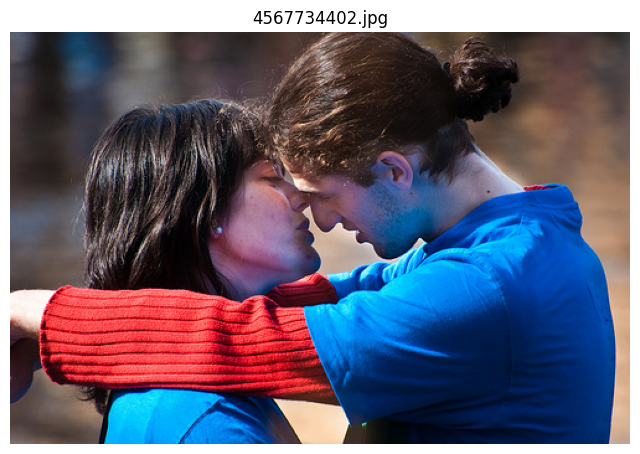

- A man in a blue and red shirt hugs a woman in a blue top .
- A man and a woman are about to kiss .
- A woman and a man getting closer .
- A couple that is about to kiss .
- Two young people are kissing .



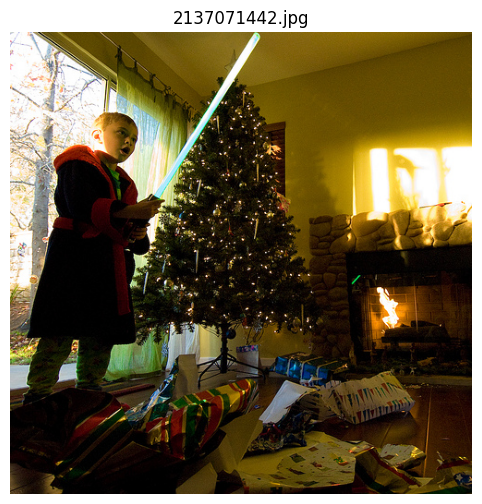

- Young boy holding a light saber in front of a Christmas tree with wrapping paper littering the floor .
- Boy indoors by Christmas tree , playing with green , light-up sword toy .
- A boy holds a light saber in front of a Christmas tree .
- A boy receives a light saber for Christmas .
- A boy looks at a new toy during christmas



In [11]:
processor.display_samples(2)

In [12]:
processor.prepare_captions(subset_ratio=CONFIG['subset_ratio'])[:20]

max_length set to 25
vocab size = 10009
split  →  train 118132 | val 14767 | test 14767


['<start> two young guys with shaggy hair look at their hands while hanging out in the yard . <end>',
 '<start> two young , white males are outside near many bushes . <end>',
 '<start> two men in green shirts are standing in a yard . <end>',
 '<start> a man in a blue shirt standing in a garden . <end>',
 '<start> several men in hard hats are operating a giant pulley system . <end>',
 '<start> workers look down from up above on a piece of equipment . <end>',
 '<start> two men working on a machine wearing hard hats . <end>',
 '<start> four men on top of a tall structure . <end>',
 '<start> three men on a large rig . <end>',
 '<start> a child in a pink dress is climbing up a set of stairs in an entry way . <end>',
 '<start> a little girl in a pink dress going into a wooden cabin . <end>',
 '<start> a little girl climbing the stairs to her playhouse . <end>',
 '<start> a little girl climbing into a wooden playhouse <end>',
 '<start> a girl going into a wooden building . <end>',
 '<start> s

In [13]:
# Create datasets
train_ds, val_ds, _ = processor.prepare_datasets()

Building datasets...


In [14]:
# Build and train model
model = ImageCaptioningModel(CONFIG, processor)
model.build_model()

Building model for single GPU...


In [15]:
model.summary()

Building model summaries...

Encoder Summary:
Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, 8, 8, 2048)        21802784  
                                                                 
 reshape (Reshape)           multiple                  0         
                                                                 
Total params: 21,802,784
Trainable params: 0
Non-trainable params: 21,802,784
_________________________________________________________________

Bahdanau Attention Summary:
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 features (InputLayer)          [(None, 64, 2048)]   0           []                               
                                                      

In [16]:
model.prime_dataset(train_ds, steps=20)

In [18]:
reduced_val = random.sample(processor.val_data, 1000)

In [19]:
# model.train(train_ds, processor.val_data)
model.train(train_ds, reduced_val)


Epoch 1/20  (ε = 0.000)
923/923 [==============================] - 156s 169ms/step - loss: 3.4605


100%|██████████| 200/200 [00:30<00:00,  6.46it/s]


BLEU-1: 0.5270
BLEU-2: 0.2919
BLEU-3: 0.1636
BLEU-4: 0.0970


100%|██████████| 1000/1000 [02:41<00:00,  6.20it/s]


BLEU-1: 0.5496
BLEU-2: 0.3090
BLEU-3: 0.1708
BLEU-4: 0.1026
Epoch 1: loss=3.5310  train-BLEU=0.0970  val-BLEU=0.1026  time=350.1s

Epoch 2/20  (ε = 0.013)
923/923 [==============================] - 157s 170ms/step - loss: 3.3570


100%|██████████| 200/200 [00:31<00:00,  6.40it/s]


BLEU-1: 0.5332
BLEU-2: 0.3106
BLEU-3: 0.1816
BLEU-4: 0.1115


100%|██████████| 1000/1000 [02:37<00:00,  6.36it/s]


BLEU-1: 0.5303
BLEU-2: 0.3055
BLEU-3: 0.1786
BLEU-4: 0.1126
Epoch 2: loss=3.3273  train-BLEU=0.1115  val-BLEU=0.1126  time=346.9s

Epoch 3/20  (ε = 0.026)
923/923 [==============================] - 157s 170ms/step - loss: 3.1183


100%|██████████| 200/200 [00:30<00:00,  6.55it/s]


BLEU-1: 0.5516
BLEU-2: 0.3186
BLEU-3: 0.1852
BLEU-4: 0.1141


100%|██████████| 1000/1000 [02:32<00:00,  6.56it/s]


BLEU-1: 0.5516
BLEU-2: 0.3181
BLEU-3: 0.1856
BLEU-4: 0.1161
Epoch 3: loss=3.1978  train-BLEU=0.1141  val-BLEU=0.1161  time=341.4s

Epoch 4/20  (ε = 0.039)
923/923 [==============================] - 157s 170ms/step - loss: 3.0738


100%|██████████| 200/200 [00:37<00:00,  5.37it/s]


BLEU-1: 0.4447
BLEU-2: 0.2587
BLEU-3: 0.1453
BLEU-4: 0.0861


100%|██████████| 1000/1000 [03:06<00:00,  5.37it/s]


BLEU-1: 0.4527
BLEU-2: 0.2647
BLEU-3: 0.1530
BLEU-4: 0.0933
Epoch 4: loss=3.1067  train-BLEU=0.0861  val-BLEU=0.0933  time=382.4s

Epoch 5/20  (ε = 0.053)
923/923 [==============================] - 157s 170ms/step - loss: 2.9908


100%|██████████| 200/200 [00:31<00:00,  6.29it/s]


BLEU-1: 0.5265
BLEU-2: 0.3049
BLEU-3: 0.1812
BLEU-4: 0.1135


100%|██████████| 1000/1000 [02:41<00:00,  6.20it/s]


BLEU-1: 0.5281
BLEU-2: 0.3060
BLEU-3: 0.1813
BLEU-4: 0.1149
Epoch 5: loss=3.0379  train-BLEU=0.1135  val-BLEU=0.1149  time=351.2s

Epoch 6/20  (ε = 0.066)
923/923 [==============================] - 157s 170ms/step - loss: 2.8628


100%|██████████| 200/200 [00:32<00:00,  6.14it/s]


BLEU-1: 0.5194
BLEU-2: 0.2931
BLEU-3: 0.1693
BLEU-4: 0.1024


100%|██████████| 1000/1000 [02:39<00:00,  6.27it/s]


BLEU-1: 0.5278
BLEU-2: 0.3005
BLEU-3: 0.1751
BLEU-4: 0.1083
Epoch 6: loss=2.9845  train-BLEU=0.1024  val-BLEU=0.1083  time=350.8s

Epoch 7/20  (ε = 0.079)
923/923 [==============================] - 158s 171ms/step - loss: 2.8351


100%|██████████| 200/200 [00:30<00:00,  6.58it/s]


BLEU-1: 0.5535
BLEU-2: 0.3197
BLEU-3: 0.1876
BLEU-4: 0.1152


100%|██████████| 1000/1000 [02:31<00:00,  6.58it/s]


BLEU-1: 0.5603
BLEU-2: 0.3266
BLEU-3: 0.1936
BLEU-4: 0.1224
Epoch 7: loss=2.9437  train-BLEU=0.1152  val-BLEU=0.1224  time=341.3s

Epoch 8/20  (ε = 0.092)
923/923 [==============================] - 158s 171ms/step - loss: 2.8599


100%|██████████| 200/200 [00:32<00:00,  6.10it/s]


BLEU-1: 0.5021
BLEU-2: 0.2852
BLEU-3: 0.1634
BLEU-4: 0.0998


100%|██████████| 1000/1000 [02:42<00:00,  6.15it/s]


BLEU-1: 0.5149
BLEU-2: 0.2971
BLEU-3: 0.1726
BLEU-4: 0.1068
Epoch 8: loss=2.9155  train-BLEU=0.0998  val-BLEU=0.1068  time=354.5s

Epoch 9/20  (ε = 0.105)
923/923 [==============================] - 158s 171ms/step - loss: 2.8623


100%|██████████| 200/200 [00:31<00:00,  6.32it/s]


BLEU-1: 0.5275
BLEU-2: 0.3040
BLEU-3: 0.1794
BLEU-4: 0.1111


100%|██████████| 1000/1000 [02:37<00:00,  6.33it/s]


BLEU-1: 0.5386
BLEU-2: 0.3130
BLEU-3: 0.1839
BLEU-4: 0.1155
Epoch 9: loss=2.8980  train-BLEU=0.1111  val-BLEU=0.1155  time=349.1s

Epoch 10/20  (ε = 0.118)
923/923 [==============================] - 158s 171ms/step - loss: 2.8214


100%|██████████| 200/200 [00:32<00:00,  6.23it/s]


BLEU-1: 0.5198
BLEU-2: 0.3008
BLEU-3: 0.1772
BLEU-4: 0.1106


100%|██████████| 1000/1000 [02:39<00:00,  6.25it/s]


BLEU-1: 0.5311
BLEU-2: 0.3073
BLEU-3: 0.1812
BLEU-4: 0.1143
Epoch 10: loss=2.8899  train-BLEU=0.1106  val-BLEU=0.1143  time=351.3s

Epoch 11/20  (ε = 0.132)
923/923 [==============================] - 157s 170ms/step - loss: 2.9134


100%|██████████| 200/200 [00:32<00:00,  6.21it/s]


BLEU-1: 0.5198
BLEU-2: 0.3008
BLEU-3: 0.1772
BLEU-4: 0.1106


100%|██████████| 1000/1000 [02:39<00:00,  6.26it/s]


BLEU-1: 0.5311
BLEU-2: 0.3073
BLEU-3: 0.1812
BLEU-4: 0.1143
Epoch 11: loss=2.8887  train-BLEU=0.1106  val-BLEU=0.1143  time=350.6s

Epoch 12/20  (ε = 0.145)
923/923 [==============================] - 158s 171ms/step - loss: 2.8227


100%|██████████| 200/200 [00:32<00:00,  6.21it/s]


BLEU-1: 0.5198
BLEU-2: 0.3008
BLEU-3: 0.1772
BLEU-4: 0.1106


100%|██████████| 1000/1000 [02:39<00:00,  6.26it/s]


BLEU-1: 0.5311
BLEU-2: 0.3073
BLEU-3: 0.1812
BLEU-4: 0.1143
Epoch 12: loss=2.8887  train-BLEU=0.1106  val-BLEU=0.1143  time=351.1s

Epoch 13/20  (ε = 0.158)
923/923 [==============================] - 158s 171ms/step - loss: 2.8037


100%|██████████| 200/200 [00:32<00:00,  6.12it/s]


BLEU-1: 0.5198
BLEU-2: 0.3008
BLEU-3: 0.1772
BLEU-4: 0.1106


 18%|█▊        | 175/1000 [00:28<02:16,  6.05it/s]


KeyboardInterrupt: 

In [ ]:
model.fine_tune_cnn(train_ds, processor.val_data, layers_to_unfreeze=8, lr=1e-5, epochs=5)

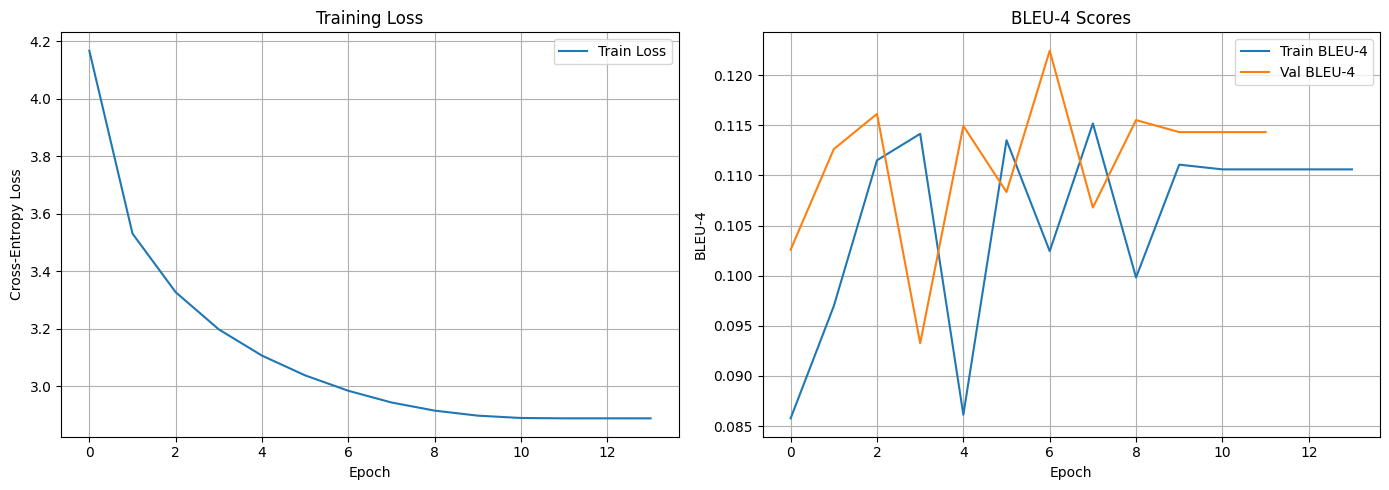

In [20]:
model.plot_history()

In [21]:
print("Evaluating on test set:")
model.evaluate_bleu(processor.test_data)

Evaluating on test set:


  0%|          | 40/14767 [00:09<55:19,  4.44it/s]  


KeyboardInterrupt: 

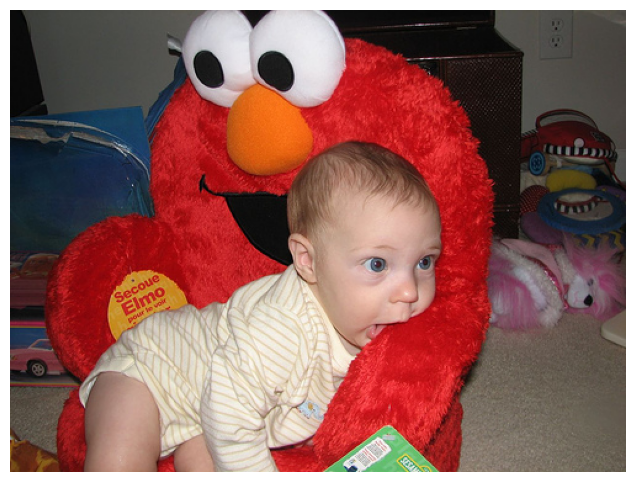

Ground-truth captions:
- A wide-eyed baby in a yellow and white striped onesie is sitting in an oversized Elmo chair that has large eyes and an orange nose , and the baby is mouthing on the arm of the chair .
- There is a child around 6 months old sitting on a large Elmo doll , looks like he is about to gum it with a Sesame Street book in their right hand .
- A blue-eyed baby lays sideways against a larger Elmo toy on the floor , looking off-camera , in a room full of other toys .
- A baby boy is entertaining himself by chewing on his Elmo chair .
- A baby boy in an elmo chair with lots of toys in the background .

Generated caption:
a little girl in a pink shirt is playing with a toy .


Audio saved to caption_audio01.mp3


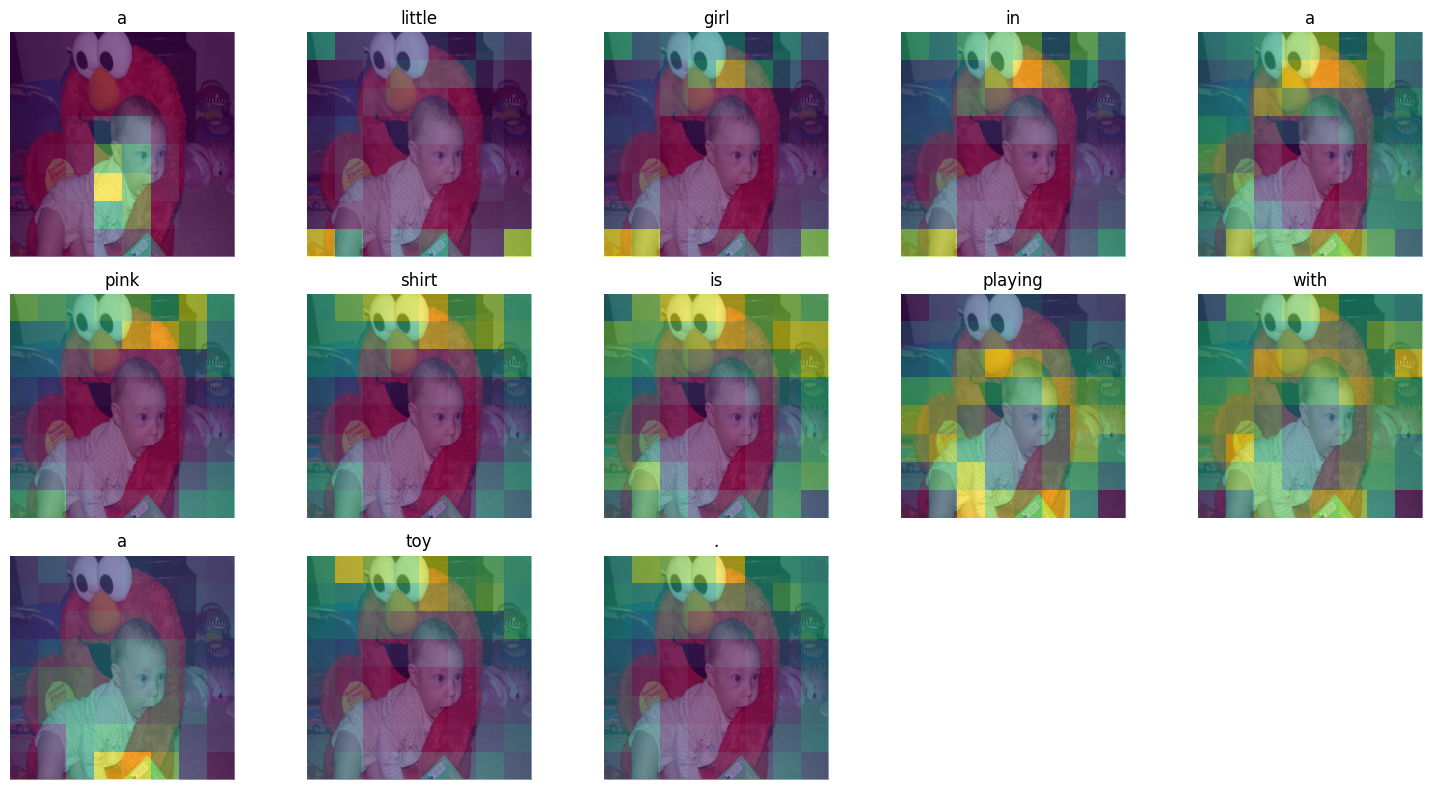

In [22]:
sample_pair = random.choice(processor.test_data)
sample_img = os.path.join(CONFIG['image_dir'], sample_pair[0])
model.demo(sample_img, filename='caption_audio01.mp3')

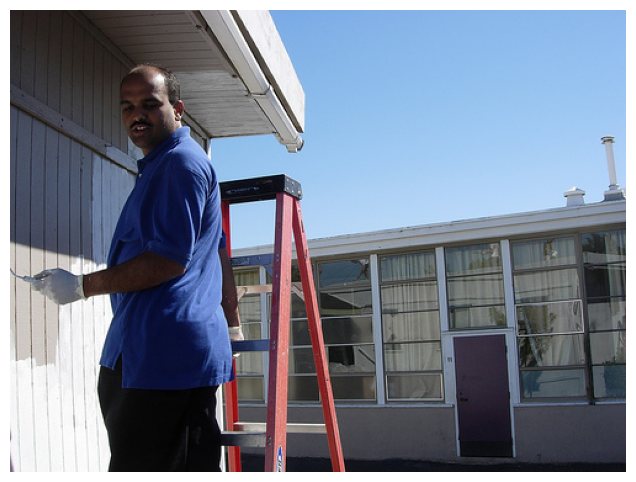

Ground-truth captions:
- A dark-skinned man is standing on a ladder painting in front of a building with many windows .
- A smiling man is painting a wall while standing next to an orange ladder .
- A man wearing a blue shirt , standing on a ladder ; painting a building .
- A man is painting the siding , of previously beige building , white .
- Man in blue shirt on a ladder painting building .

Generated caption:
a man in a white shirt is standing in front of a building .


Audio saved to caption_audio02.mp3


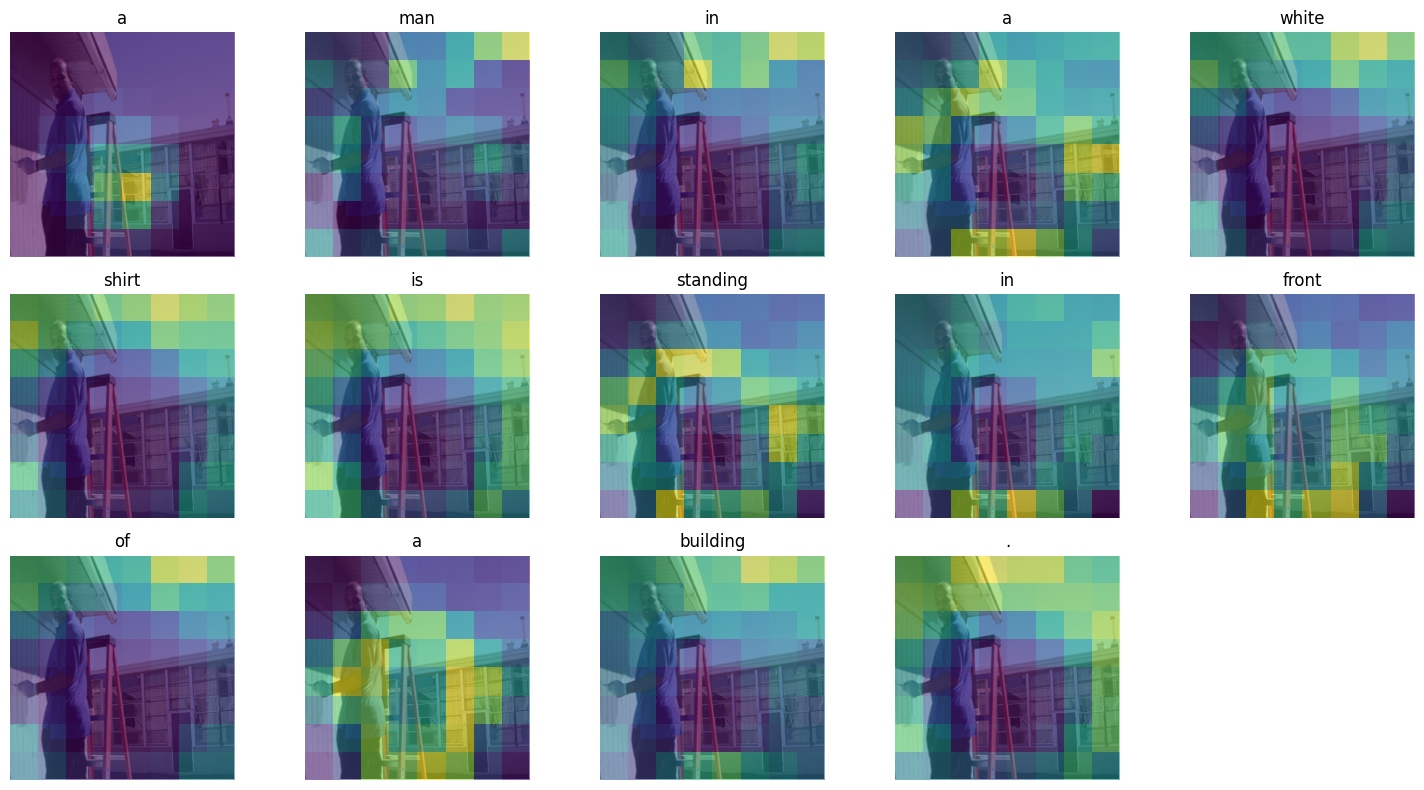

In [23]:
sample_pair = random.choice(processor.test_data)
sample_img = os.path.join(CONFIG['image_dir'], sample_pair[0])
model.demo(sample_img, filename='caption_audio02.mp3')

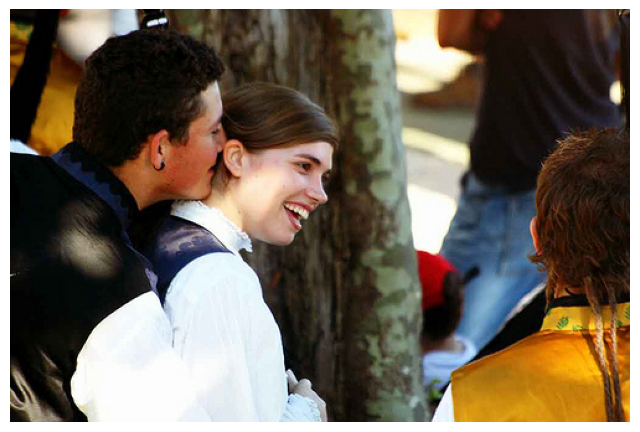

Ground-truth captions:
- A woman smiling while a man embraces her from behind and nuzzles her neck just behind her right ear .
- A man in a black vest is whispering in the ear of a smiling girl .
- A man kisses the neck of a woman sitting on his lap .
- A couple hugging and smiling .
- A man hugs a smiling girl .

Generated caption:
a man in a white shirt is holding a microphone .


Audio saved to caption_audio03.mp3


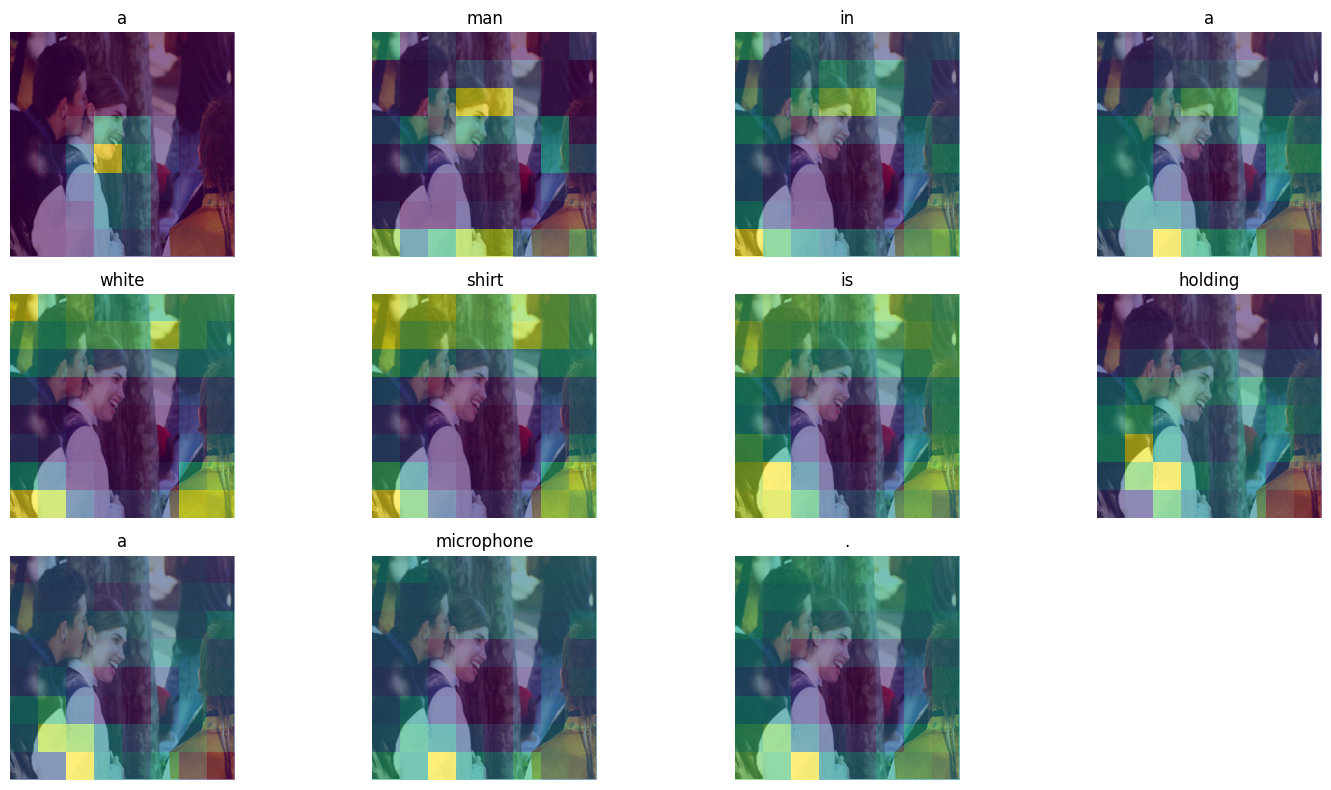

In [24]:
sample_pair = random.choice(processor.test_data)
sample_img = os.path.join(CONFIG['image_dir'], sample_pair[0])
model.demo(sample_img, filename='caption_audio03.mp3')

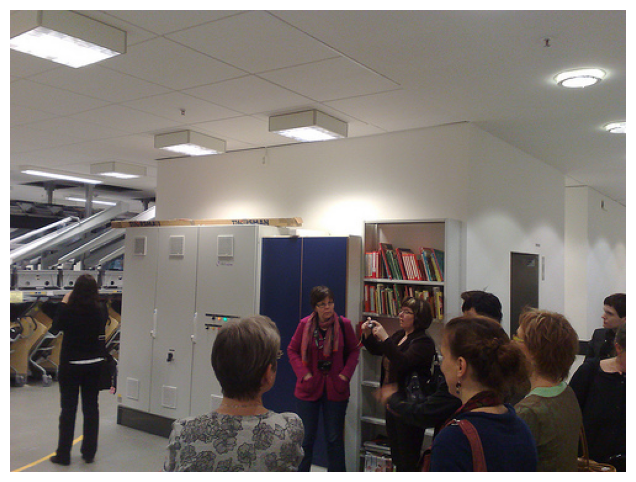

Ground-truth captions:
- A tour guide explaining to a group of onlookers the process 's of the machine they are looking at while a woman in black takes a photo .
- A bunch of women stand in a crowded room taking pictures and standing around .
- A group of 7 women and a man in a building taking pictures and talking .
- A woman takes a picture along side a group .
- A woman taking a photograph .

Generated caption:
a man in a white shirt is standing in front of a building .


Audio saved to caption_audio04.mp3


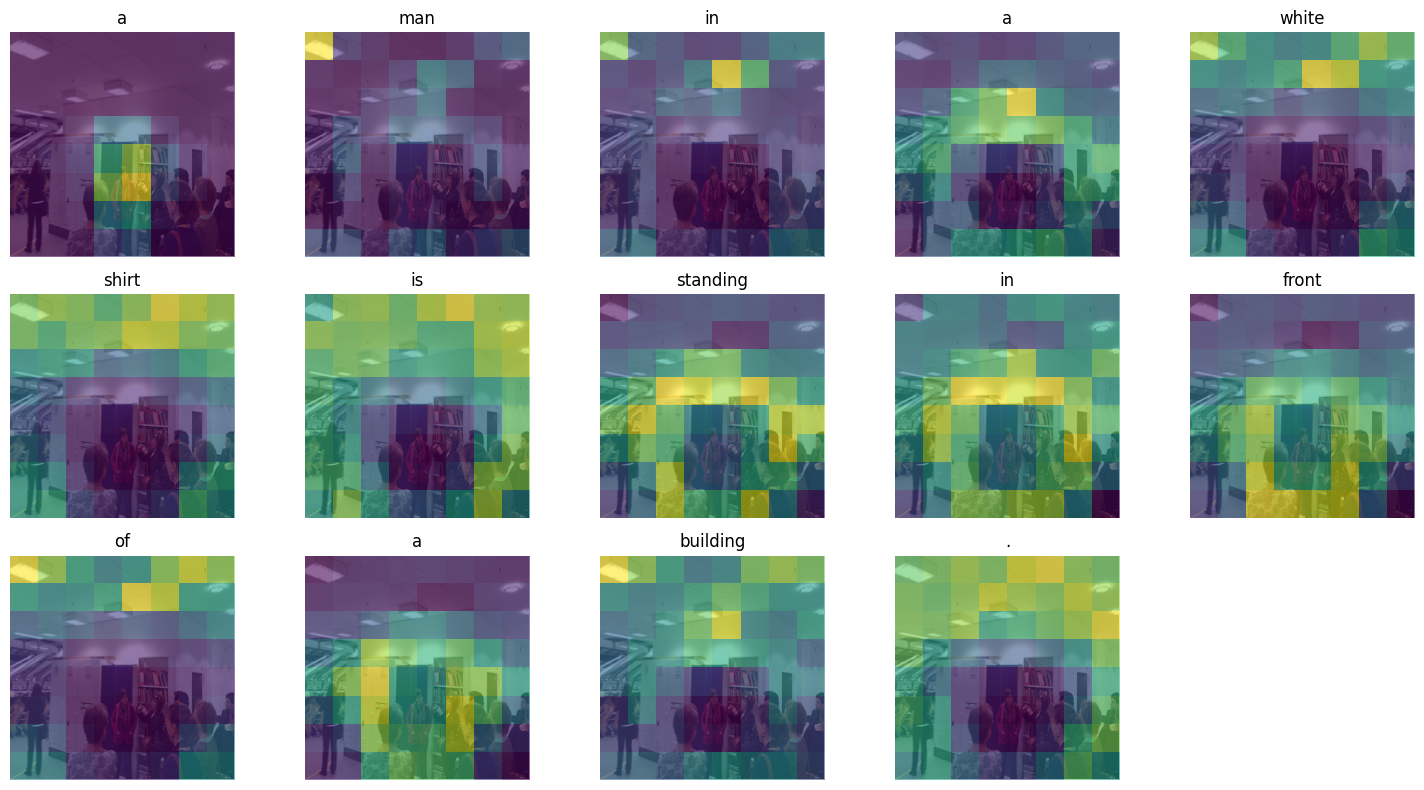

In [25]:
sample_pair = random.choice(processor.test_data)
sample_img = os.path.join(CONFIG['image_dir'], sample_pair[0])
model.demo(sample_img, filename='caption_audio04.mp3')

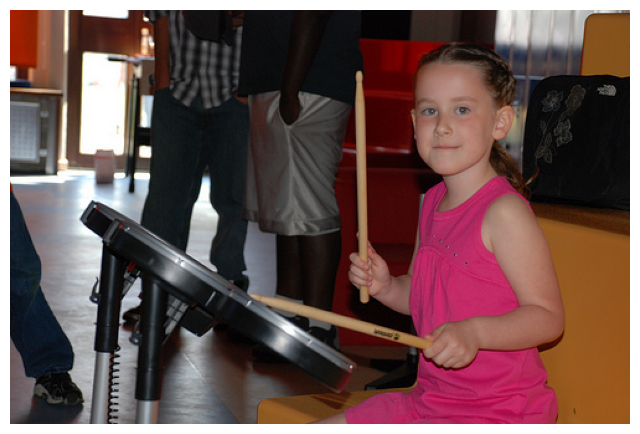

Ground-truth captions:
- Small girl in a pink dress is playing electronic drum pads with sticks .
- A girl in a pink dress playing with a toy drum set .
- A little girl in pink playing the drums .
- A girl in pink plays the drums .
- young girl playing the drums .

Generated caption:
a man in a white shirt is playing a guitar .


Audio saved to caption_audio05.mp3


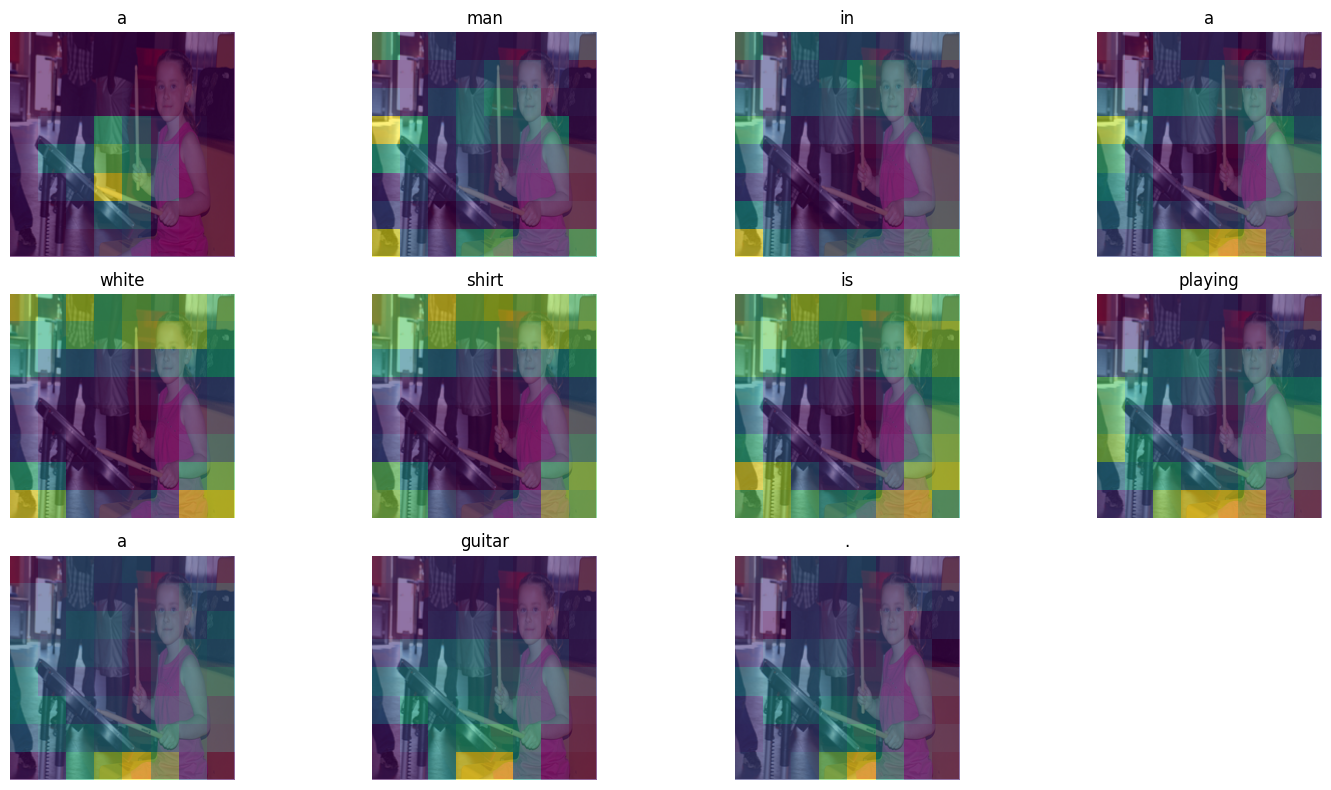

In [26]:
sample_pair = random.choice(processor.test_data)
sample_img = os.path.join(CONFIG['image_dir'], sample_pair[0])
model.demo(sample_img, filename='caption_audio05.mp3')

In [ ]:
# processor.display_samples(10)

In [ ]:
# # -------- 1-image over-fit check ---------------------------------
# one_pair   = [processor.train_data[0]]          # (img, caption)
# one_ds     = processor.build_dataset(one_pair,
#                                      shuffle=False, cache=False
#                                     ).repeat()  # infinite

# OVF_CFG = CONFIG.copy()
# OVF_CFG.update({
#     'epochs'       : 1,       # we’ll drive the loop ourselves
#     'batch_size'   : 1,
#     'checkpoint_dir': './checkpoints/onefit'
# })

# one_model = ImageCaptioningModel(OVF_CFG, processor)
# one_model.build_model()

# def show_image(path, title=''):
#     img = Image.open(path)
#     plt.figure(figsize=(6, 4))
#     plt.imshow(img)
#     plt.axis('off')
#     if title: plt.title(title)
#     plt.show()

# img_path = os.path.join(OVF_CFG['image_dir'], one_pair[0][0])
# show_image(img_path, 'Single-image over-fit target')

# # run ~1 000 gradient steps
# steps = 1000
# for step, (img_t, tgt, cap_len) in zip(range(steps), one_ds):
#     loss = one_model.train_step(img_t, tgt, cap_len)
#     if (step+1) % 100 == 0:
#         print(f"step {step+1}: loss={loss.numpy():.3f}")
#         print("→", " ".join(one_model.greedy_decode(img_path)))

# print("\nFinal caption:")
# print(" ".join(one_model.greedy_decode(img_path)))
